In [12]:
import torch
import graphviz
import math

# 课程准备

## PyTorch基本使用

### 什么是张量

张量(tensor)是一个由数值构成的数组，可以有多个维度。

构建一个一维数组，其包含12个`int64`类型的元素

In [3]:
x: torch.Tensor = torch.arange(12)
print(f"shape: {x.shape}, number element: {x.numel()}, type of element: {x.dtype}")
print(x)

shape: torch.Size([12]), number element: 12, type of element: torch.int64
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


可以使用`reshape`改变一个张量的形状

In [4]:
x = x.reshape(3, 4)
print("shape: ", x.shape)
print(x)

shape:  torch.Size([3, 4])
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


### 常用的张量操作

#### cat
可以使用`cat`将多个有着相同形状(shape)的张量拼接起来，其中`dim`表示拼接的维度

比如现在有两个维度为$n$的张量$X$和$Y$，`dim`可取的范围为$[-n, n-1]$

$$
cat((X, Y), dim=d)=\begin{cases}
cat((X, Y), dim=d+n) &, d \lt 0 \\\\
X \ \mathbf{join} \ Y &, d=0 \\\\
X[i_0][i_1]\cdots[i_{d-1}]+Y[i_0][i_1]\cdots[i_{d-1}], i_k \in \{0, 1, 2, \cdots X.shape[k]-1\} &, d > 0
\end{cases}$$

其中

$$Z=X\ \mathbf{join} \ Y=[X[0], X[1], \cdots, Y[0], Y[1], \cdots]$$

In [16]:
X = torch.arange(12, dtype=torch.float32).reshape((2, 2, 3))
Y = torch.arange(12, 24, dtype=torch.float32).reshape((2, 2, 3))
print(f"X={X}\n Y={Y}")
torch.cat((X, Y))

X=tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.]],

        [[ 6.,  7.,  8.],
         [ 9., 10., 11.]]])
 Y=tensor([[[12., 13., 14.],
         [15., 16., 17.]],

        [[18., 19., 20.],
         [21., 22., 23.]]])


tensor([[[ 0.,  1.,  2., 12., 13., 14.],
         [ 3.,  4.,  5., 15., 16., 17.]],

        [[ 6.,  7.,  8., 18., 19., 20.],
         [ 9., 10., 11., 21., 22., 23.]]])

#### sum
对一个张量执行求和操作，包含`axis`表示沿着该轴求和，其中$axis \in \{-ndim, -ndim-1, \cdots, -1, 0, 1, \cdots,ndim-1\}$，其中$ndim$是张量的维度。

默认`axis=None`，此时是求张量所有元素的和，返回的是一个标量

In [19]:
X = torch.arange(24).reshape(2, 3, 4)
X.sum()

(tensor(276), 276.0)

当`axis`是整数时，和`cat`一样，如果$axis \lt 0$，相当于$axis+ndim$。对于任意的$axis \ge 0$其结果为

$$\sum_{i=0}^{X.shape[axis-1]-1}X[:, \cdots, i, :, \cdots]$$

其中$i$所在的维度是`axis`表示的维度

In [23]:
print(X.sum(axis=0) == X[0, :, :] + X[1, :, :])
print(X.sum(axis=1) == X[:, 0, :] + X[:, 1, :] + X[:, 2, :])
print(X.sum(axis=2) == X[:, :, 0]+X[:, :, 1]+X[:, :, 2]+X[:, :, 3])

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])
tensor([[True, True, True, True],
        [True, True, True, True]])
tensor([[True, True, True],
        [True, True, True]])


`axis`也可以包含多个值

$$\sum_{i_1=0}\cdots\sum_{i_k=0}X[:,\cdots,i_1,:,\cdots,:,i_k,\cdots,:]$$

In [24]:
expect =torch.zeros(4)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        expect += X[i, j, :]
print(X.sum(axis=(0,1)) == expect)

tensor([True, True, True, True])


### 广播(broadcasting)

在正常情况，对两个张量执行任意操作的前提是两个张量有一样的形状。但是PyTorch允许两个张量即使形状不同也可以执行，这种机制称为[广播](https://numpy.org/doc/stable/user/basics.broadcasting.html#basics-broadcasting)。

```python
>>> a = np.array([1.0, 2.0, 3.0])
>>> b = np.array([2.0, 2.0, 2.0])
>>> a * b
array([2.,  4.,  6.])
```

`PyTorch`在执行张量的操作之前会检查两个张量的形状，从右往左一个一个元素比较

$$\begin{aligned}
A: a_0 \times &a_1 \cdots \times a_n \\
B: \ \ \ \ \ \ \ \ &b_0 \cdots \times b_n
\end{aligned}$$

只有下面两种情况，检查才会成功，否则会抛出`ValueError`的异常
- 元素相等
- 其中一个是1

当检查通过后，但是张量形状不一致时，会将张量广播成形状一致的张量，比如

$$\begin{aligned}
A&: 8 \times 1 \times 6 \times 1 \\
B&: \ \ \ \ \ \ \ 7 \times 1 \times 5 \\
Result&: 8\times7\times6\times5
\end{aligned}$$

对于需要广播的张量，比如维度$d_{old}$需要广播到$d_{new}$，那么会将$\{d_{old+1}, d_{old+2}, \cdots, d_{old+n-1}\}$复制$d_{new}-1$个

比如
```python
>>> a = np.array([[ 0.0,  0.0,  0.0],
...               [10.0, 10.0, 10.0],
...               [20.0, 20.0, 20.0],
...               [30.0, 30.0, 30.0]])
>>> b = np.array([1.0, 2.0, 3.0])
>>> a + b
array([[  1.,   2.,   3.],
        [11.,  12.,  13.],
        [21.,  22.,  23.],
        [31.,  32.,  33.]])
>>> b = np.array([1.0, 2.0, 3.0, 4.0])
>>> a + b
Traceback (most recent call last):
ValueError: operands could not be broadcast together with shapes (4,3) (4,)
```

![](../resources/broadcasting_1.png)

![](../resources/broadcasting_2.png)

In [10]:
a = torch.arange(3).reshape(3, 1)
b = torch.arange(2).reshape(1, 2)
print(f"a={a}\nb={b}\nbroadcasted_a={torch.cat((a, a), dim=1)}\nbroadcasted_b={torch.cat((b, b, b))}")
a + b

a=tensor([[0],
        [1],
        [2]])
b=tensor([[0, 1]])
broadcasted_a=tensor([[0, 0],
        [1, 1],
        [2, 2]])
broadcasted_b=tensor([[0, 1],
        [0, 1],
        [0, 1]])


tensor([[0, 1],
        [1, 2],
        [2, 3]])

## 自动求导

### 矩阵求导

考虑一个函数

$$function(input)$$

其中$input$和$function$可以是标量、向量和矩阵中的任意一种，因此总共有六种组合。

矩阵求导就是针对不同类型的$input$和$function$，能够给出统一形式求解偏导数的一种规则。

标量可以看作维度为1的向量，因此标量、向量可以统一处理。而对于矩阵的情况，需要先将矩阵转为向量，称之为向量化。因此不论标量、向量和矩阵都可以统一视为向量来处理。

$$\mathbf{vec}(\boldsymbol{X}_{m \times n})=\begin{bmatrix}
x_{11} \\
x_{21} \\
\vdots \\
x_{m1} \\
\vdots \\
x_{1n} \\
x_{2n} \\
\vdots \\
x_{mn}
\end{bmatrix}$$

### 雅可比矩阵

借助雅可比矩阵可以对$\mathbb{R}^m\to\mathbb{R}^n$的函数求解其偏导数矩阵。

假设$f_1, f_2, \cdots, f_n$是关于$x_1, x_2, \cdots, x_m$的函数，并且每个函数对于各个自变量的偏导数都存在，定义如下函数矩阵为雅可比矩阵(Jacobian Matrix)

$$
J(x_1, x_2, \cdots, x_m)=\frac{\partial (f_1, f_2, \cdots, f_n)}{\partial (x_1, x_2, \cdots, x_m)}=\begin{bmatrix}
\frac{\partial f_1}{\partial x_1}& \frac{\partial f_1}{\partial x_2}& \cdots& \frac{\partial f_1}{\partial x_m} \\
\frac{\partial f_2}{\partial x_1}& \frac{\partial f_2}{\partial x_2}& \cdots& \frac{\partial f_2}{\partial x_m} \\
\vdots& \vdots& \vdots& \vdots \\
\frac{\partial f_n}{\partial x_1}& \frac{\partial f_n}{\partial x_2}& \cdots& \frac{\partial f_n}{\partial x_m} \\
\end{bmatrix}_{n \times m}
$$

### 链式法则
对于$\boldsymbol{f}(\boldsymbol{w})$，其中$\boldsymbol{f}$是$n$维向量，$\boldsymbol{w}$是$p$维向量，并且$\boldsymbol{w}=\boldsymbol{w}(\boldsymbol{x})$，其中$\boldsymbol{x}$为$m$维向量，借助雅可比矩阵和矩阵乘法，有

$$
\begin{aligned}
\frac{\partial (\boldsymbol{f})}{\partial (\boldsymbol{x})} 
&= \begin{bmatrix}
\frac{\partial f_1}{\partial x_1}& \frac{\partial f_1}{\partial x_2}& \cdots& \frac{\partial f_1}{\partial x_m} \\
\frac{\partial f_2}{\partial x_1}& \frac{\partial f_2}{\partial x_2}& \cdots& \frac{\partial f_2}{\partial x_m} \\
\vdots& \vdots& \vdots& \vdots \\
\frac{\partial f_n}{\partial x_1}& \frac{\partial f_n}{\partial x_2}& \cdots& \frac{\partial f_n}{\partial x_m} \\
\end{bmatrix}_{n \times m} \\\\

&= \begin{bmatrix}
\sum_{i=1}^{p}\frac{\partial f_1}{\partial w_i}\frac{\partial w_i}{\partial x_1}& \sum_{i=1}^{p}\frac{\partial f_1}{\partial w_i}\frac{\partial w_i}{\partial x_2}& \cdots& \sum_{i=1}^{p}\frac{\partial f_1}{\partial w_i}\frac{\partial w_i}{\partial x_m} \\
\sum_{i=1}^{p}\frac{\partial f_2}{\partial w_i}\frac{\partial w_i}{\partial x_1}& \sum_{i=1}^{p}\frac{\partial f_2}{\partial w_i}\frac{\partial w_i}{\partial x_2}& \cdots& \sum_{i=1}^{p}\frac{\partial f_2}{\partial w_i}\frac{\partial w_i}{\partial x_m} \\
\vdots& \vdots& \vdots& \vdots \\
\sum_{i=1}^{p}\frac{\partial f_n}{\partial w_i}\frac{\partial w_i}{\partial x_1}& \sum_{i=1}^{p}\frac{\partial f_n}{\partial w_i}\frac{\partial w_i}{\partial x_2}& \cdots& \sum_{i=1}^{p}\frac{\partial f_n}{\partial w_i}\frac{\partial w_i}{\partial x_m} \\
\end{bmatrix}_{n \times m} \\\\

&= \begin{bmatrix}
\frac{\partial f_1}{\partial w_1}& \frac{\partial f_1}{\partial w_2}& \cdots& \frac{\partial f_1}{\partial w_p}\\
\frac{\partial f_2}{\partial w_1}& \frac{\partial f_2}{\partial w_2}& \cdots& \frac{\partial f_2}{\partial w_p}\\
\vdots& \vdots& \vdots& \vdots \\
\frac{\partial f_n}{\partial w_1}& \frac{\partial f_n}{\partial w_2}& \cdots& \frac{\partial f_n}{\partial w_p}\\
\end{bmatrix}_{n \times p} \cdot 
\begin{bmatrix}
\frac{\partial w_1}{\partial x_1}& \frac{\partial w_1}{\partial x_2}& \cdots& \frac{\partial w_1}{\partial x_m} \\
\frac{\partial w_2}{\partial x_1}& \frac{\partial w_2}{\partial x_2}& \cdots& \frac{\partial w_2}{\partial x_m} \\
\vdots& \vdots& \vdots& \vdots \\
\frac{\partial w_p}{\partial x_1}& \frac{\partial w_p}{\partial x_2}& \cdots& \frac{\partial w_p}{\partial x_m} \\
\end{bmatrix}_{p \times m} \\\\

&= \frac{\partial (\boldsymbol{f})}{\partial (\boldsymbol{w})}\frac{\partial (\boldsymbol{w})}{\partial (\boldsymbol{x})}

\end{aligned}
$$

上述$\boldsymbol{w}$称为中间变量，链式法则还可以推广到包含多个中间变量，设$\boldsymbol{w_i}$为第$i$个中间变量，并且总共有$q$个中间变量，那么有

$$\frac{\partial (\boldsymbol{f})}{\partial (\boldsymbol{x})}=\frac{\partial (\boldsymbol{f})}{\partial (\boldsymbol{w_q})}\frac{\partial (\boldsymbol{w_{q}})}{\partial (\boldsymbol{w_{q-1}})}\cdots\frac{\partial (\boldsymbol{w_2})}{\partial (\boldsymbol{w_1})}\frac{\partial (\boldsymbol{w_1})}{\partial (\boldsymbol{x})}$$

### 自动求导

在大部分机器学习的算法，都是对某个损失函数$L$优化，得到使得损失函数$L$值最小的模型参数。在监督学习中的[逻辑回归](../SupervisedLearning/logistic_regression.ipynb)中我们介绍过梯度下降法，通过计算损失函数的$L$的梯度，同时梯度的反方向是函数值下降最快的方向来得到损失函数$L$的最小值，完成学习。

运用梯度下降法的关键是计算一个函数在给定变量上的偏导数（梯度），在[逻辑回归](../SupervisedLearning/logistic_regression.ipynb)中式通过显示定义经验误差的导函数`drhd`来计算梯度的。

自动求导是计算梯度的一种机制，可以避免手动写导函数的代码，其主要原理是链式法则。

自动求导实现的关键是计算图，计算图定义了`tensor`的运算步骤，`tensor`的计算可以分成两种情况
- 二元运算，比如加法、减法等需要两个变量的运算
- 一元运算，比如取负、乘方、三角函数等只需要一个变量

因此可以把一个运算表达式拆成多个中间变量，每次运算最多只有两个中间变量参与运算，比如

$$f(x_1, x_2)=ln(x_1)+x_1x_2-sin(x_2)$$

计算图如下，其中$v_i, 0 \lt i \lt 5$都是中间变量

![](../resources/autograd2.png)

接下来根据计算图可以计算偏导数（梯度）了，有两种计算方式：前向累积和反向传播。

以如下函数来解释下两种计算模式的区别

$$\begin{cases}
f(x_1, x_2) &= ln(x_1)+x_1x_2-sin(x_2) \\
g(x_1, x_2) &= x_1x_2 - x_2 + x_1^2
\end{cases}$$

计算图如下

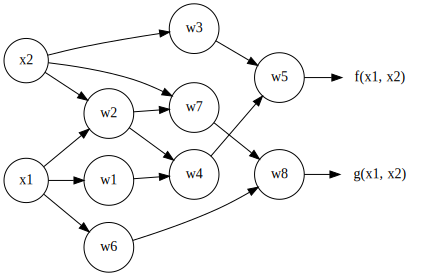

In [9]:
G = graphviz.Digraph()
G.attr(rankdir="LR")
G.attr("node", shape="circle")
G.node("x1", label="x1")
G.node("x2", label="x2")
G.node("ln(x1)", label="w1")
G.node("x1x2", label="w2")
G.node("sin(x2)", label="w3")
G.node("ln(x1)+x1x2", label="w4")
G.node("ln(x1)+x1x2-sin(x2)", label="w5")
G.node("f(x1, x2)", shape="plaintext")
G.node("x1^2", label="w6")
G.node("x1x2-x2", label="w7")
G.node("x1x2-x2+x1^2", label="w8")
G.node("g(x1, x2)", shape="plaintext")

G.edge("x1", "ln(x1)")
G.edge("x1", "x1x2"), G.edge("x2", "x1x2")
G.edge("x2", "sin(x2)")
G.edge("ln(x1)", "ln(x1)+x1x2"), G.edge("x1x2", "ln(x1)+x1x2")
G.edge("ln(x1)+x1x2", "ln(x1)+x1x2-sin(x2)"), G.edge("sin(x2)", "ln(x1)+x1x2-sin(x2)")
G.edge("ln(x1)+x1x2-sin(x2)", "f(x1, x2)")
G.edge("x1", "x1^2")
G.edge("x1x2", "x1x2-x2"), G.edge("x2", "x1x2-x2")
G.edge("x1^2", "x1x2-x2+x1^2"), G.edge("x1x2-x2", "x1x2-x2+x1^2")
G.edge("x1x2-x2+x1^2", "g(x1, x2)")
G

#### 前向累积

计算变量$x_1$的偏导数为例，需要计算
$$\frac{\partial f}{\partial x_1} , \ \frac{\partial g}{\partial x_1}$$

根据链式法则有

$$\begin{aligned}
\frac{\partial f}{\partial x_1} &= (\frac{\partial w_1}{\partial x_1}\frac{\partial w_4}{\partial w_1} + \frac{\partial w_2}{\partial x_1}\frac{\partial w_4}{\partial w_2})\frac{\partial w_5}{\partial w_4}\frac{\partial f}{\partial w_5} \\\\

\frac{\partial g}{\partial x_1} &= (\frac{\partial w_2}{\partial x_1}\frac{\partial w_7}{\partial w_2}\frac{\partial w_8}{\partial w_7}+\frac{\partial w_6}{\partial x_1}\frac{\partial w_8}{\partial w_6})\frac{\partial g}{\partial w_8}
\end{aligned}$$

定义$\dot{w}_i$为$\frac{\partial w_i}{\partial x_1}$，前向累积计算在$(x_1, x_2)=(2, 5)$的梯度的过程如下

$$\begin{aligned}
\hline
&\dot{x_1} = 1\\
&\dot{x_2} = 0 \\
\hline \\
&\dot{w_1} = \frac{1}{{ln(x_1)}'} \times \dot{x_1} = \frac{1}{2} \\
&\dot{w_2} = \dot{x_1} \times x_2+x_1 \times \dot{x_2} = 5 \\
&\dot{w_3} = cos(x_2) \times \dot{x_2} =0 \\
&\dot{w_4} = \dot{w_1} + \dot{w_2} = 5.5 \\
&\dot{w_5} = \dot{w_4} - \dot{w_3} = 5.5 \\
&\dot{w_6} = 2x_1 \times \dot{x_1} = 4 \\
&\dot{w_7} = \dot{w_2} - \dot{x_2} = 5 \\
&\dot{w_8} = \dot{w_6} + \dot{w_7} = 9 \\
\hline
&\dot{f} = \dot{w_5} = 5.5 \\
&\dot{g} = \dot{w_8} = 9 
\end{aligned}$$

上面的计算过程，对于输入$(x_1, x_2)$，如果期望求$x_1$的偏导数，那么就将$\dot{x_1}$设置为$1$，其余变量设置为$0$。接下来从计算图的$x_1$出发，计算每个中间变量$\dot{w_i}$，前向累积结束后，可以得到所有输出对$x_1$的偏导数。

上面的例子其雅可比矩阵为

$$J=\begin{bmatrix}
\frac{\partial f}{\partial x_1}& \frac{\partial f}{\partial x_2} \\
\frac{\partial g}{\partial x_1}& \frac{\partial g}{\partial x_2}
\end{bmatrix}$$

那么上述前向累积的过程可以表示为

$$
J\dot{\boldsymbol{x}}=\begin{bmatrix}
\frac{\partial f}{\partial x_1}& \frac{\partial f}{\partial x_2} \\
\frac{\partial g}{\partial x_1}& \frac{\partial g}{\partial x_2}
\end{bmatrix}
\begin{bmatrix}
1 \\
0
\end{bmatrix}=\begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial g}{\partial x_1}
\end{bmatrix}
$$

更一般地，对于任意方向$\vec{r}$，计算函数$f_1, ..., f_m$在$\vec{r}$的方向导数为

$$
J\vec{r}=\begin{bmatrix}
\frac{\partial f_1}{\partial x_1}& \cdots& \frac{\partial f_1}{\partial x_n} \\
\vdots& \vdots& \vdots \\
\frac{\partial f_m}{\partial x_1}& \cdots& \frac{\partial f_m}{\partial x_n}
\end{bmatrix}
\begin{bmatrix}
r_1 \\
\vdots \\
r_n
\end{bmatrix}
$$

这也称为雅可比向量积(Jacobian-vector products)。

因此如果需要求解梯度向量，对于$n$维$\boldsymbol{x}$向量，总共需要$n$次雅可比向量积。

#### 反向传播

反向传播和前向传播相反，还是看上面的例子，现在计算$\frac{\partial f}{\partial \boldsymbol{x}}$的梯度看下反向传播的计算过程，使用$\bar{w_i}$表示$\frac{\partial f}{\partial w_i}$

$$\begin{aligned}
\hline
&\bar{f} = 1 \\
&\bar{g} = 0 \\
\hline 
&\bar{w_5}=\bar{f}\frac{\partial f}{\partial w_5}=1 \\
&\bar{w_4}=\bar{w_5}\frac{\partial w_5}{\partial w_4}=1 \\
&\bar{w_3}=\bar{w_5}\frac{\partial w_5}{\partial w_3}=-1 \\
&\bar{w_2}=\bar{w_4}\frac{\partial w_4}{\partial w_2}=1 \\
&\bar{w_1}=\bar{w_4}\frac{\partial w_4}{\partial w_1}=1 \\
\hline
&\bar{x_2}=\bar{w_3}\frac{\partial w_3}{\partial x_2}+\bar{w_2}\frac{\partial w_2}{\partial x_2}=1.716 \\
&\bar{x_1}=\bar{w_1}\frac{\partial w_1}{\partial x_1}+\bar{w_2}\frac{\partial w_2}{\partial x_1}=5.5

\end{aligned}$$

一次反向传播能够计算$f$的梯度，使用雅可比向量积表示就是

$$
J^\top\bar{\boldsymbol{f}}=\begin{bmatrix}
\frac{\partial f}{\partial x_1}& \frac{\partial g}{\partial x_1} \\
\frac{\partial f}{\partial x_1}& \frac{\partial g}{\partial x_1}
\end{bmatrix} 
\begin{bmatrix}
\frac{\partial f}{\partial f} \\
\frac{\partial f}{\partial g}
\end{bmatrix}=\begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2}
\end{bmatrix}
$$

更一般地，对于函数$l(x_1, x_2, \cdots, x_n)$，其中$l$有$m$个中间变量$f_1, f_2, \cdots, f_m$，如果需要计算$l$地梯度，可以通过雅可比矩阵计算得出
$$
J^\top\vec{r}=\begin{bmatrix}
\frac{\partial f_1}{\partial x_1}& \cdots& \frac{\partial f_m}{\partial x_1} \\
\vdots& \vdots& \vdots \\
\frac{\partial f_1}{\partial x_n}& \cdots& \frac{\partial f_m}{\partial x_n} 
\end{bmatrix}
\begin{bmatrix}
\frac{\partial l}{\partial f_1} \\
\vdots \\
\frac{\partial l}{\partial f_m}
\end{bmatrix}
$$


那么反向传播总共需要$m$次雅可比向量积就能够计算所有梯度了。

#### 前向累积和反向传播对比
1. 对于有$n$个自变量，$m$个因变量，现在需要计算所有因变量的梯度，那么前向累积需要$n$次雅可比向量积才能完成，反向传播需要$m$次雅可比向量积才能完成。
2. 反向传播需要保存中间变量的值，比如
$$
\frac{\partial l}{\partial w_1}=\frac{\partial l}{\partial w_2}\frac{\partial w_2}{\partial w_1}
$$
此时需要将中间变量$w_1$保存下来，才能计算出$\frac{\partial w_2}{\partial w_1}$，因此反向传播更耗费内存资源。

In [20]:
def f(x1, x2):
    return torch.log(x1) + x1 @ x2 - torch.sin(x2)

def g(x1, x2):
    return x1 @ x2 - x2 + torch.pow(x1, 2)

x1 = torch.tensor([2.0], requires_grad=True)
x2 = torch.tensor([5.0], requires_grad=True)
y = torch.cat((f(x1, x2), g(x1, x2)))
y.backward(gradient=torch.tensor([1, 0]), retain_graph=True)
print(f"f({x1[0]}, {x2[0]})={y[0]}, gradient=[{x1.grad[0]}, {x2.grad[0]}]")
x1.grad.zero_(), x2.grad.zero_()
y.backward(gradient=torch.tensor([0, 1]))
print(f"g({x1[0]}, {x2[0]})={y[1]}, gradient=[{x1.grad[0]}, {x2.grad[0]}]")

f(2.0, 5.0)=11.652071952819824, gradient=[5.5, 1.71633780002594]
g(2.0, 5.0)=9.0, gradient=[9.0, 1.0]


## 资料

- [自动求导](https://arxiv.org/pdf/1502.05767.pdf)
- [矩阵求导](https://zhuanlan.zhihu.com/p/263777564)
- [一个简单的自动求导实现](https://zhuanlan.zhihu.com/p/263777564)
- [PyTorch自动求导文档](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)